In [43]:
import pandas as pd

# Load the provided Excel file
file_path = '/content/sample_data/시계열분석_복합SCFI_2017.xlsx'
data = pd.read_excel(file_path)

# Displaying the first few rows of the dataset to understand its structure
data.head()

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings

# Converting 'YYYYMM' to datetime and setting it as index
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')
data.set_index('YYYYMM', inplace=True)

# Splitting the dataset into train and test
# Keeping the last 6 months for testing
train_data = data[:-6]
test_data = data[-6:]

# Displaying the first few rows of the train and test datasets
train_data.head(), test_data.head()


(              SCFI_C
 YYYYMM              
 2014-01-01  1174.866
 2014-02-01  1069.362
 2014-03-01   969.145
 2014-04-01  1078.462
 2014-05-01  1137.112,
              SCFI_C
 YYYYMM             
 2017-04-01  834.060
 2017-05-01  860.922
 2017-06-01  869.764
 2017-07-01  878.540
 2017-08-01  864.205)

# 도표 18-3. ADF 테스트 파이썬코드와 결과

In [44]:
from statsmodels.tsa.stattools import adfuller
# ADF 테스트
adf_test = adfuller(train_data['SCFI_C'])

# ADF 테스트 결과 출력
adf_output = pd.Series(adf_test[0:4], \
                       index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output['Critical Value (%s)' % key] = value

adf_output

Test Statistic                 -1.802635
p-value                         0.379154
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64

In [45]:
# Defining the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generating all different combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Measure RMSE for each combination
best_rmse = float('inf')
best_pdq = None
predictions = None

warnings.filterwarnings("ignore")  # Ignore warnings from ARIMA model fits

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=6)  # Forecasting the next 6 months
        rmse = sqrt(mean_squared_error(test_data, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_pdq = param
            predictions = forecast
    except:
        continue

best_pdq, best_rmse, predictions


((0, 0, 1),
 44.9566647389506,
 2017-04-01    848.335166
 2017-05-01    824.681287
 2017-06-01    824.681287
 2017-07-01    824.681287
 2017-08-01    824.681287
 2017-09-01    824.681287
 Freq: MS, Name: predicted_mean, dtype: float64)

# 도표 18-2. 파라미터 변화에 따른 RMSE

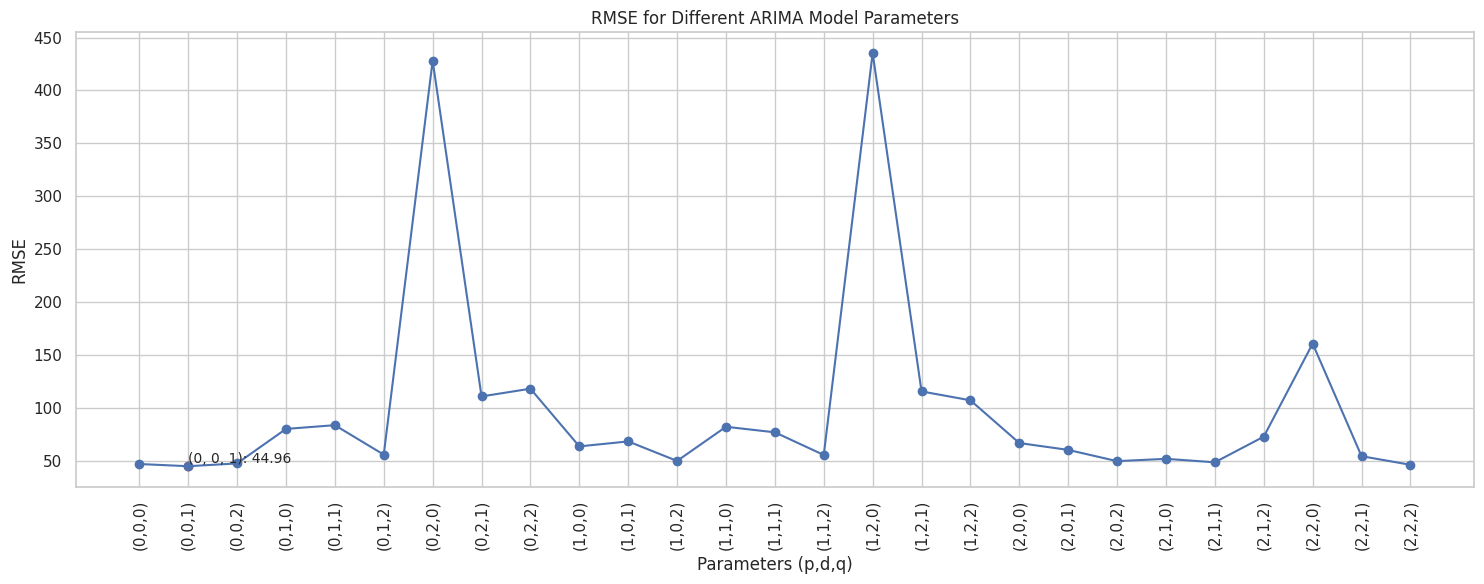

In [46]:
import matplotlib.pyplot as plt

# Redoing the ARIMA modeling process to store the RMSE values for each parameter combination
rmse_values = []
parameters = []

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=6)
        rmse = sqrt(mean_squared_error(test_data, forecast))
        rmse_values.append(rmse)
        parameters.append(param)
    except:
        continue

# Converting parameters to string format for better plotting
parameters_str = [f'({p},{d},{q})' for p, d, q in parameters]

# Plotting the RMSE values for each parameter combination
plt.figure(figsize=(15, 6))
plt.plot(parameters_str, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Different ARIMA Model Parameters')
plt.xlabel('Parameters (p,d,q)')
plt.ylabel('RMSE')
plt.xticks(rotation=90)

# Highlighting the parameter with the lowest RMSE
lowest_rmse_idx = rmse_values.index(min(rmse_values))
plt.scatter(parameters_str[lowest_rmse_idx], rmse_values[lowest_rmse_idx], color='red')
plt.text(parameters_str[lowest_rmse_idx], rmse_values[lowest_rmse_idx],
         f'{parameters[lowest_rmse_idx]}: {rmse_values[lowest_rmse_idx]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()


# 도표 18-2.  ARIMA(0,0,1)의 예측 결과

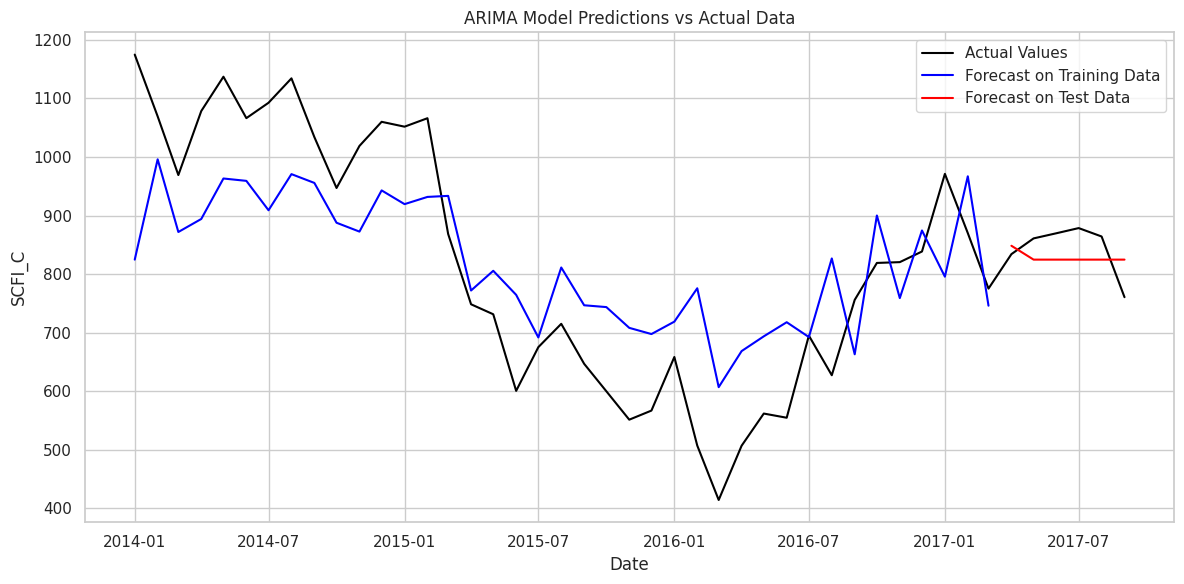

In [47]:
# Fitting the model with the best parameters on the entire training dataset
best_model = ARIMA(train_data, order=best_pdq)
best_model_fit = best_model.fit()

# Forecasting the next 6 months (test data period)
forecast_test_period = best_model_fit.forecast(steps=6)

# Plotting the training data predictions, test data predictions, and actual values
plt.figure(figsize=(12, 6))

# Plotting the actual values for the entire dataset
plt.plot(data, color='black', label='Actual Values')

# Plotting the forecasted values for the training data
train_forecast = best_model_fit.predict(start=train_data.index[0], end=train_data.index[-1])
plt.plot(train_data.index, train_forecast, color='blue', label='Forecast on Training Data')

# Plotting the forecasted values for the test data
plt.plot(test_data.index, forecast_test_period, color='red', label='Forecast on Test Data')

plt.title('ARIMA Model Predictions vs Actual Data')
plt.xlabel('Date')
plt.ylabel('SCFI_C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
test_data['Prediction'] = forecast_test_period
test_data

,SCFI_C,Prediction
YYYYMM,,
2017-04-01,834.060,848.335166
2017-05-01,860.922,824.681287
2017-06-01,869.764,824.681287
2017-07-01,878.540,824.681287
2017-08-01,864.205,824.681287
2017-09-01,760.540,824.681287


별첨 데이터 파악

# 별첨. 트랜드 파악 및 시계열분해

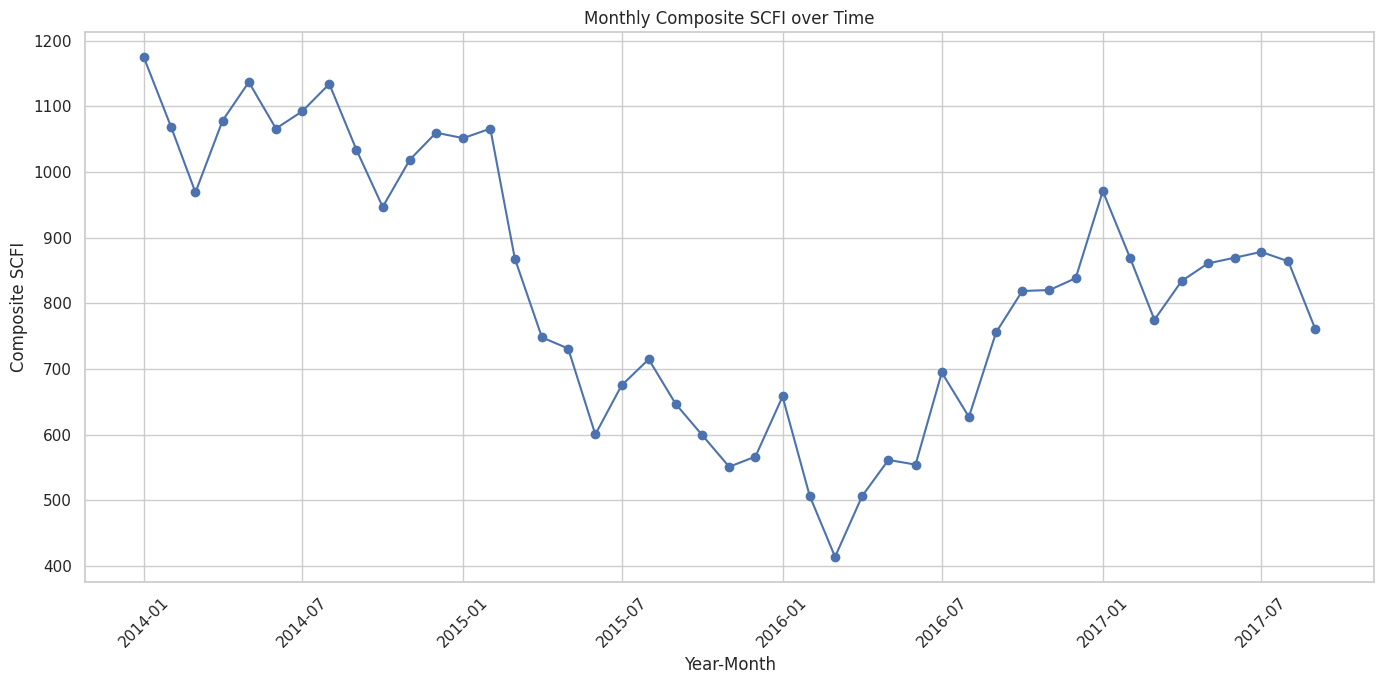

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_excel(file_path)
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')

# Setting plot style for better readability
sns.set(style="whitegrid")

# Plotting the SCFI_C to visually inspect for seasonality
plt.figure(figsize=(14, 7))
plt.plot(data['YYYYMM'], data['SCFI_C'], marker='o', linestyle='-')
plt.title('Monthly Composite SCFI over Time')
plt.xlabel('Year-Month')
plt.ylabel('Composite SCFI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


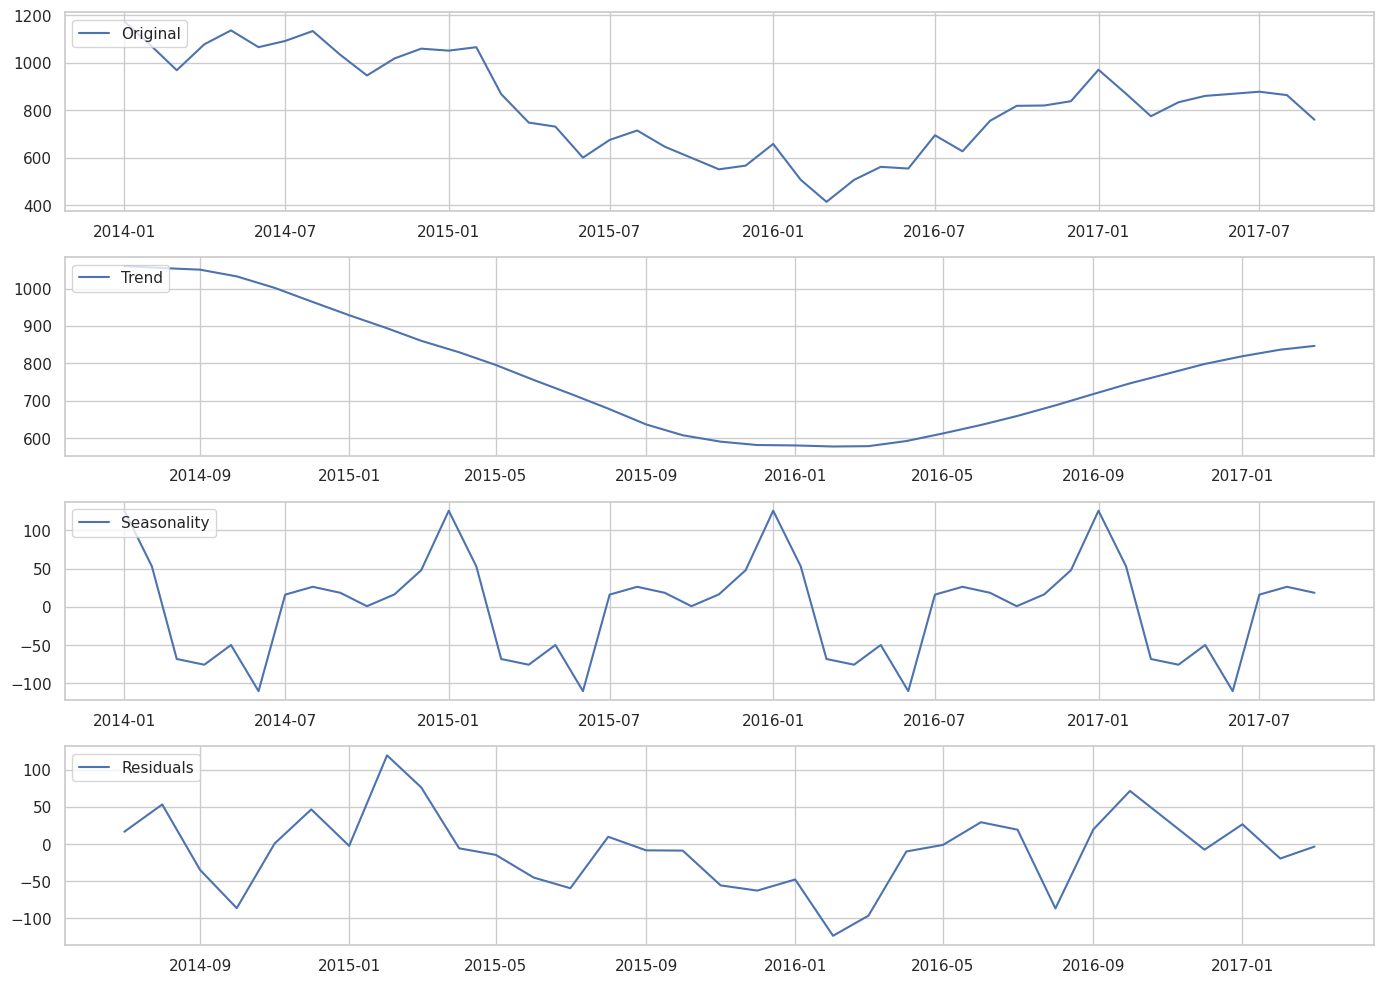

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

data.set_index('YYYYMM', inplace=True)

# Setting the frequency of the time series as 12 for monthly data
decomposition = seasonal_decompose(data['SCFI_C'], model='additive', period=12)

# Extracting the trend, seasonality, and residuals from the decomposition
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the decomposed components of the time series
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['SCFI_C'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# 별첨. 통계적 계절성 확인

In [54]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 월별 데이터 생성
data['Month'] = data.index.month

# ANOVA 분석
# SCFI_C를 종속 변수로, 월(Month)을 독립 변수로 하여 회귀 모델을 생성합니다. C(Month)는 월을 범주형 변수로 처리한다.
anova_model = smf.ols('SCFI_C ~ C(Month)', data=data).fit()

anova_results = sm.stats.anova_lm(anova_model, typ=2)
print(anova_results)


                sum_sq    df         F    PR(>F)
C(Month)  1.322713e+05  11.0  0.235584  0.992866
Residual  1.684384e+06  33.0       NaN       NaN


In [55]:
import scipy.stats as stats

# 계절성 검정 (Seasonal Test)
# 월별 데이터 생성
monthly_means = data.groupby(data.index.month).mean()

# 월별 평균 검정
f_val, p_val = stats.f_oneway(*[data[data.index.month == i]['SCFI_C'] for i in range(1, 13)])
print(f'F-value: {f_val}, p-value: {p_val}')


F-value: 0.23558392307355958, p-value: 0.9928655328183204


# 별첨. 잔차 ACF, PACF

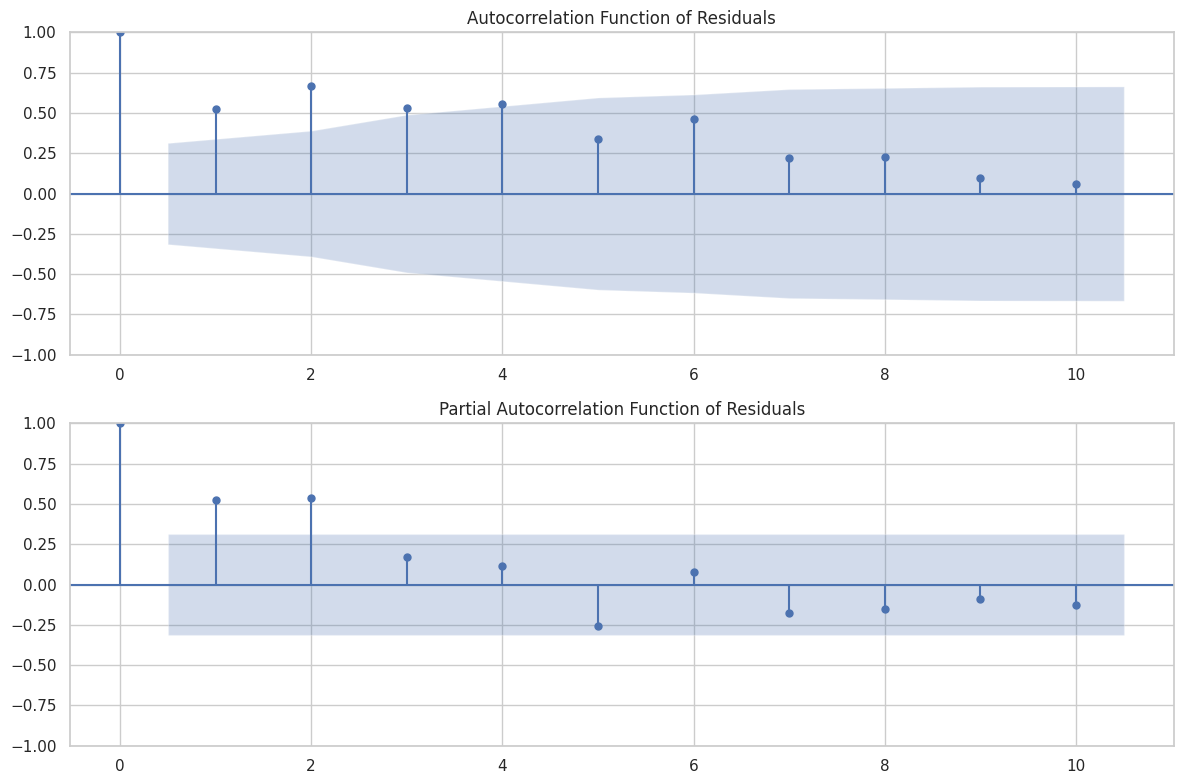

count     39.000000
mean      -0.001250
std      141.176302
min     -268.689693
25%     -115.357896
50%      -16.594491
75%      112.155176
max      350.184713
dtype: float64

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 이미 ARIMA(0,0,1) 모델을 적합한 상태에서의 잔차를 추출합니다
residuals = best_model_fit.resid

# 재시도: 잔차의 요약 통계와 ACF, PACF 플롯 생성
residuals_summary = residuals.describe()

plt.figure(figsize=(12, 8))

# ACF 플롯
plt.subplot(211)
plot_acf(residuals, ax=plt.gca(), lags=10)
plt.title('Autocorrelation Function of Residuals')

# PACF 플롯
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca(), lags=10)
plt.title('Partial Autocorrelation Function of Residuals')

plt.tight_layout()
plt.show()

residuals_summary
